In [1]:
# ============================================================
# 03 - Modelagem GLM: Frequência (Poisson) e Severidade (Gamma)
# Fonte: SUSEP AUTOSEG (2019-2021)
# Autor: Arthur Pontes Motta
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson, Gamma
from statsmodels.genmod.families.links import Log
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Caminhos
PROCESSED_PATH = '../data/processed'
FIGURES_PATH = '../reports/figures'

# ============================================================
# 1. CARREGAR DADOS
# ============================================================

df = pd.read_parquet(f'{PROCESSED_PATH}/autoseg_model.parquet')

features = (
    ['sexo_bin', 'faixa_etaria', 'idade_veiculo', 'log_is_media'] +
    [c for c in df.columns if c.startswith('regiao_')]
)

print(f"Shape: {df.shape}")
print(f"Features: {len(features)}")
print(f"Zeros em freq_colisao_rel: {(df['freq_colisao_rel'] == 0).mean():.1%}")

Shape: (8868406, 73)
Features: 44
Zeros em freq_colisao_rel: 90.6%


In [2]:
# ============================================================
# 2. PREPARAÇÃO PARA MODELAGEM
# ============================================================

# Split temporal: treino 2019-2020 | teste 2021 (sem data leakage)
df_train = df[df['ano'] < 2021].copy()
df_test  = df[df['ano'] == 2021].copy()

print(f"Treino: {len(df_train):,} linhas ({len(df_train)/len(df):.1%})")
print(f"Teste:  {len(df_test):,} linhas ({len(df_test)/len(df):.1%})")

# Offset: log da exposição (padrão atuarial)
offset_train = np.log(df_train['exposicao'])
offset_test  = np.log(df_test['exposicao'])

# Dataset de severidade: apenas onde houve sinistro
df_sev_train = df_train[
    (df_train['freq_colisao'] > 0) &
    (df_train['severidade_colisao'] > 0) &
    (np.isfinite(df_train['severidade_colisao']))
].copy()

df_sev_test = df_test[
    (df_test['freq_colisao'] > 0) &
    (df_test['severidade_colisao'] > 0) &
    (np.isfinite(df_test['severidade_colisao']))
].copy()

print(f"\nTreino severidade: {len(df_sev_train):,} linhas")
print(f"Teste severidade:  {len(df_sev_test):,} linhas")

Treino: 6,520,676 linhas (73.5%)
Teste:  2,347,730 linhas (26.5%)

Treino severidade: 636,381 linhas
Teste severidade:  193,214 linhas


In [3]:
# ============================================================
# 3. GLM DE FREQUÊNCIA — POISSON COM OFFSET
# ============================================================

# Amostra de 500k (suficiente para GLM robusto, evita MemoryError)
SAMPLE_SIZE = 500_000
df_train_sample = df_train.sample(n=SAMPLE_SIZE, random_state=42)

X_train_s = df_train_sample[features].astype(float)
X_train_s['idade_veiculo'] = X_train_s['idade_veiculo'].fillna(
    X_train_s['idade_veiculo'].median()
)
X_train_s = sm.add_constant(X_train_s)

y_freq_s  = df_train_sample['freq_colisao_rel']
offset_s  = np.log(df_train_sample['exposicao'])

print(f"Amostra treino: {len(df_train_sample):,} linhas")

print("Treinando GLM Poisson (frequência)...")
glm_freq = sm.GLM(
    y_freq_s,
    X_train_s,
    family=Poisson(link=Log()),
    offset=offset_s
).fit()

print("✓ Modelo treinado!")
print(glm_freq.summary())

Amostra treino: 500,000 linhas
Treinando GLM Poisson (frequência)...
✓ Modelo treinado!
                 Generalized Linear Model Regression Results                  
Dep. Variable:       freq_colisao_rel   No. Observations:               500000
Model:                            GLM   Df Residuals:                   499955
Model Family:                 Poisson   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67583.
Date:                Sat, 21 Feb 2026   Deviance:                       87173.
Time:                        15:07:56   Pearson chi2:                 8.79e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01371
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [4]:
# ============================================================
# 4. GLM DE SEVERIDADE — GAMMA COM LINK LOG
# ============================================================

df_sev_sample = df_sev_train.sample(
    n=min(200_000, len(df_sev_train)), random_state=42
)

X_sev_s = df_sev_sample[features].astype(np.float64)
X_sev_s['idade_veiculo'] = X_sev_s['idade_veiculo'].fillna(
    X_sev_s['idade_veiculo'].median()
)

y_sev_s = df_sev_sample['severidade_colisao'].clip(
    lower=1,
    upper=df_sev_sample['severidade_colisao'].quantile(0.99)
).astype(np.float64)

# Remover colunas de variância zero antes de adicionar constante
var = X_sev_s.var()
cols_baixa_var = var[var < 1e-10].index.tolist()
if cols_baixa_var:
    X_sev_s = X_sev_s.drop(columns=cols_baixa_var)

print(f"Amostra severidade: {len(df_sev_sample):,} linhas")
print(f"Severidade média: R${y_sev_s.mean():,.2f}")
print(f"Colunas removidas (var~0): {cols_baixa_var}")

# Inicializar params para convergência estável
n_params = X_sev_s.shape[1]
start_params = np.zeros(n_params)
start_params[0] = np.log(y_sev_s.mean())

print("\nTreinando GLM Gamma (severidade)...")
glm_sev = sm.GLM(
    y_sev_s,
    X_sev_s,
    family=Gamma(link=Log())
).fit(start_params=start_params, method='newton')

print("✓ Modelo treinado!")
print(glm_sev.summary())

Amostra severidade: 200,000 linhas
Severidade média: R$9,852.46
Colunas removidas (var~0): []

Treinando GLM Gamma (severidade)...
✓ Modelo treinado!
                 Generalized Linear Model Regression Results                  
Dep. Variable:     severidade_colisao   No. Observations:               200000
Model:                            GLM   Df Residuals:                   199956
Model Family:                   Gamma   Df Model:                           43
Link Function:                    Log   Scale:                          279.30
Method:                        newton   Log-Likelihood:            -2.8411e+06
Date:                Sat, 21 Feb 2026   Deviance:                   2.9286e+05
Time:                        15:07:59   Pearson chi2:                 5.58e+07
No. Iterations:                    14   Pseudo R-squ. (CS):         -0.0006121
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|   

AVALIAÇÃO DO MODELO GLM
MAE:         R$571.17
RMSE:        R$3,469.83
Correlação:  0.0408

Prêmio puro médio observado:  R$338.65
Prêmio puro médio predito:    R$318.11


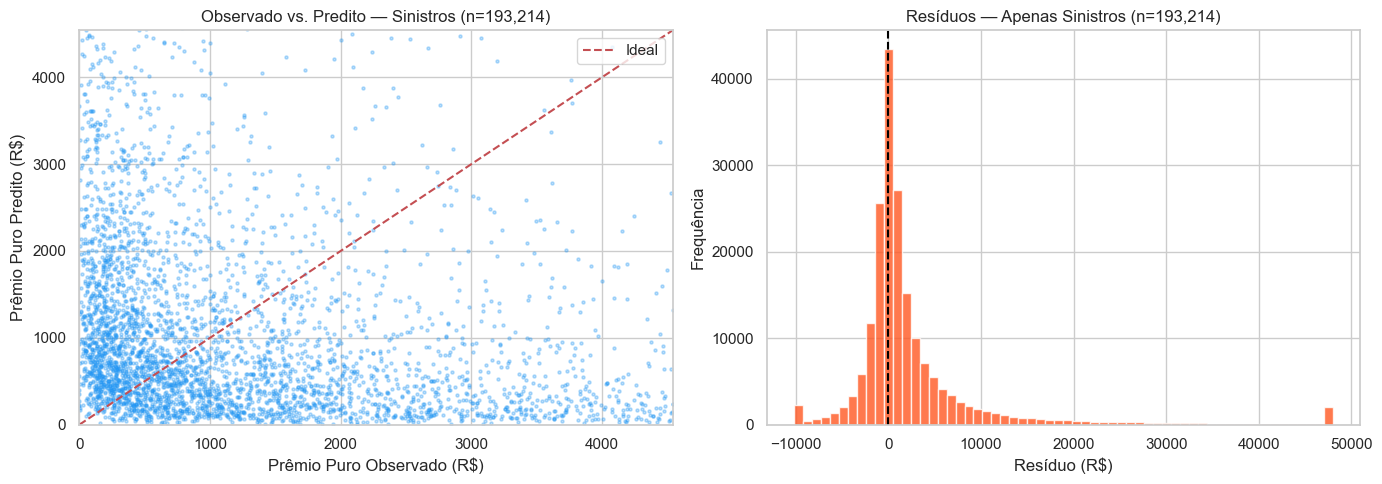

Figura salva.


In [5]:
# ============================================================
# 5. PRÊMIO PURO E AVALIAÇÃO
# ============================================================

# Preparar dados de teste
X_test_clean = df_test[features].astype(float)
X_test_clean['idade_veiculo'] = X_test_clean['idade_veiculo'].fillna(
    X_train_s['idade_veiculo'].median()
)

# Alinhar colunas com o modelo de severidade
cols_sev = X_sev_s.columns.tolist()
for col in cols_sev:
    if col not in X_test_clean.columns:
        X_test_clean[col] = 0
X_test_clean = X_test_clean[cols_sev].astype(np.float64)

# Predições de frequência (com constante e offset)
X_test_freq = sm.add_constant(X_test_clean, has_constant='add')
pred_freq = glm_freq.predict(X_test_freq, offset=np.log(df_test['exposicao']))

# Predições de severidade
pred_sev = glm_sev.predict(X_test_clean)

# Prêmio puro = frequência × severidade
premio_puro_pred = pred_freq * pred_sev
premio_puro_obs  = df_test['indeniz_colisao'] / df_test['exposicao']

# Métricas
mae  = mean_absolute_error(premio_puro_obs, premio_puro_pred)
rmse = np.sqrt(mean_squared_error(premio_puro_obs, premio_puro_pred))
corr = np.corrcoef(premio_puro_obs, premio_puro_pred)[0, 1]

print("=" * 50)
print("AVALIAÇÃO DO MODELO GLM")
print("=" * 50)
print(f"MAE:         R${mae:,.2f}")
print(f"RMSE:        R${rmse:,.2f}")
print(f"Correlação:  {corr:.4f}")
print(f"\nPrêmio puro médio observado:  R${premio_puro_obs.mean():,.2f}")
print(f"Prêmio puro médio predito:    R${premio_puro_pred.mean():,.2f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Observado vs Predito — apenas onde houve sinistro
ax1 = axes[0]
mask_scatter = (premio_puro_obs > 0).values
obs_sin  = premio_puro_obs[mask_scatter]
pred_sin = premio_puro_pred[mask_scatter]

rng = np.random.default_rng(42)
idx = rng.choice(len(obs_sin), min(5000, len(obs_sin)), replace=False)

ax1.scatter(obs_sin.iloc[idx], pred_sin.iloc[idx],
            alpha=0.3, s=5, color='#2196F3')
max_val = min(obs_sin.quantile(0.95), pred_sin.quantile(0.95))
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=1.5, label='Ideal')
ax1.set_xlabel('Prêmio Puro Observado (R$)')
ax1.set_ylabel('Prêmio Puro Predito (R$)')
ax1.set_title(f'Observado vs. Predito — Sinistros (n={mask_scatter.sum():,})')
ax1.legend()
ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)

# 2. Resíduos — apenas onde houve sinistro observado
ax2 = axes[1]
mask_sinistro = premio_puro_obs > 0
residuos_sinistro = premio_puro_obs[mask_sinistro] - premio_puro_pred[mask_sinistro]
residuos_clip = residuos_sinistro.clip(
    residuos_sinistro.quantile(0.01),
    residuos_sinistro.quantile(0.99)
)
ax2.hist(residuos_clip, bins=60, color='#FF5722', edgecolor='white', alpha=0.8)
ax2.axvline(0, color='black', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Resíduo (R$)')
ax2.set_ylabel('Frequência')
ax2.set_title(f'Resíduos — Apenas Sinistros (n={mask_sinistro.sum():,})')

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/03_glm_avaliacao.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva.")

In [6]:
# ============================================================
# 6. SALVAR MODELOS GLM
# ============================================================

import pickle
import os

MODELS_PATH = '../models'
os.makedirs(MODELS_PATH, exist_ok=True)

with open(f'{MODELS_PATH}/glm_freq.pkl', 'wb') as f:
    pickle.dump(glm_freq, f)

with open(f'{MODELS_PATH}/glm_sev.pkl', 'wb') as f:
    pickle.dump(glm_sev, f)

# Salvar colunas do modelo de severidade (tem colunas removidas)
with open(f'{MODELS_PATH}/glm_sev_cols.pkl', 'wb') as f:
    pickle.dump(X_sev_s.columns.tolist(), f)

# Salvar mediana para imputação de NaN
with open(f'{MODELS_PATH}/idade_veiculo_median.pkl', 'wb') as f:
    pickle.dump(float(X_train_s['idade_veiculo'].median()), f)

print("✓ Modelos GLM salvos!")
print(f"  glm_freq.pkl")
print(f"  glm_sev.pkl")
print(f"  glm_sev_cols.pkl")
print(f"  idade_veiculo_median.pkl")

✓ Modelos GLM salvos!
  glm_freq.pkl
  glm_sev.pkl
  glm_sev_cols.pkl
  idade_veiculo_median.pkl
